<a href="https://colab.research.google.com/github/AlexanderVaz15/Final_16B/blob/main/BullFolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**BullFolio**

Joseph Kiger, Wildan Levitt, Alexander Vazques

github: https://github.com/wildanlevitt/16B_BullFolio


# Joseph stuff

In [8]:
import pandas as pd
import numpy as np
import yfinance as yf  # to fetch historical price data
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from sklearn.decomposition import PCA
# Step 1: Data Collection
import yfinance as yf
class StockPortfolio:
    '''
    This class is to help us manage data regarding a given list of stock tickers
    tickList: list or string of our stock tickers
    tickerList: Dictionary of our ticker names with the yf ticker object
    timePeriod: how far we want to look back on historical data,  must be one of: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max ,,, defaulting to 1 year
    data: A dataframe provided by yahoo finance api that gives us the daily open, close, adjusted close prices, highs and lows, and trading volume
            information for our tickers during a specified time period
    '''
    def __init__(self, tickList):
        self.tickerList = yf.Tickers(tickList).tickers
        self.timePeriod = '1y'
        self.data = yf.download(list(self.tickerList.keys()), period = self.timePeriod, auto_adjust = False) #tickers.tickers is a dictionary of yf ticker objects with keys being the ticker names
    def getSimpleChangeHistory(self, feature: str) -> pd.DataFrame:
        '''
        feature is what feature we want to see the % change in for that day, eg Close Price, Volume, Open Price
        This method calculates the daily closing price pct changes,
        calculated by taking the difference between the kth and (k-1)th day's non-adjusted closing price
        then dividing this difference by the (k-1)th close price to find the pct change after the kth day's market close
        '''
        #data = yf.download(list(self.YfTickers.keys()), period = timePeriod, auto_adjust = False) #tickers.tickers is a dictionary of yf ticker objects with keys being the ticker names
        self.simpleReturn = self.data[(feature,)].pct_change().dropna()
        return self.simpleReturn
    def getLogChangeHistory(self, feature: str) -> pd.DataFrame:
        '''
        This Method calculates the log return for each day, ln(Close Price of Today/close price of yesterday)
        '''
        self.logReturn = np.log(self.data[(feature,)]) - np.log(self.data[(feature,)].shift(1)).dropna()
        return self.logReturn
    def change_timePeriod(self, newTimePeriod: str) -> None:
        '''
        This method changes the time period for the historical data we want to look at
        '''
        self.timePeriod = newTimePeriod
        self.data = yf.download(list(self.tickerList.keys()), period = self.timePeriod, auto_adjust = False) #tickers.tickers is a dictionary of yf ticker objects with keys being the ticker names
        '''
    def simpleReturnVolatility(self) -> float:
        We Actually don't need this
        mean = self.getSimpleReturnHistory().mean()
        std = self.getSimpleReturnHistory().std()
        return std
    def logReturnVolatility(self) -> float:
        I don't think we need this either
        mean = self.getLogReturnHistory().mean()
        std = self.getLogReturnHistory().std()
        return std
        '''
    def simpleMovingAverage(self,  feature: str, dayWindow: int) -> pd.DataFrame:
        '''
        This method calculates the Simple Moving Average for a specific time window of our non-adjusted Close Prices
        '''
        return self.data[(feature, )].rolling(window = dayWindow).mean()
    def exponentialMovingAverage(self, feature: str, dayWindow: int) -> pd.DataFrame:
        '''
        feature: Any of the features of our stock data, examples: Volume Close Price

        This method calculates the exponential moving average for a specific time window of our non-adjusted Close Prices
        This one is more weighted by recent prices, so looking at the difference between the Simple Moving and Exponential moving
        can give some insight into the momentum of the price changes
        '''
        return self.data[(feature, )].ewm(span=dayWindow, adjust=False).mean()
    def extractColumns(self, cols:list,tick:list)->pd.DataFrame:
        newData = self.data.loc[:, (cols, tick)]
        return newData
    def plotMovingAveragesDiff(self,feature: str, timeWindow: int, ticker: str) -> go.Figure:
        '''
        This method creates a figure displaying the moving averages and their difference for a desired time window and ticker
        '''
        df1 = self.simpleMovingAverage(feature,timeWindow)
        df2 = self.exponentialMovingAverage(feature,timeWindow)
        df3 = self.exponentialMovingAverage(feature,timeWindow) - self.simpleMovingAverage(feature,timeWindow)
        newDf = pd.DataFrame()
        newDf['SMA'] = df1[ticker]
        newDf['EMA'] = df2[ticker]
        newDf['Diff'] = df3[ticker]
        fig = go.Figure()

        # Add SMA trace (primary y-axis)
        fig.add_trace(go.Scatter(x=newDf.index, y=newDf['SMA'], mode='lines', name='SMA'))

        # Add EMA trace (primary y-axis)
        fig.add_trace(go.Scatter(x=newDf.index, y=newDf['EMA'], mode='lines', name='EMA'))

        # Add Difference trace (secondary y-axis)
        fig.add_trace(go.Scatter(x=newDf.index, y=newDf['Diff'], mode='lines', name='Difference', yaxis='y2'))

        # Update layout for two y-axes
        diff_min = newDf['Diff'].min()
        diff_max = newDf['Diff'].max()
        padding = (diff_max - diff_min) * 0.1  # 10% padding
        fig.update_layout(
            title=f"Simple Moving Average and Exponential Moving Average of {ticker}'s {feature} over {timeWindow} day window, and Their Difference with Dual Y-Axis for {ticker}",
            xaxis=dict(title='Date'),
            yaxis=dict(title='SMA and EMA'),
            yaxis2=dict(
                title='Difference',
                overlaying='y',
                side='right',
                showgrid=False,
                zeroline=True,
                zerolinecolor='gray',
                range=[diff_min - padding, diff_max + padding]
            ),
            legend=dict(x=0, y=-1)
        )
        return fig
    def MovingAverages(self, feature: str, timeWindow: str) -> pd.DataFrame:
        df1 = self.simpleMovingAverage(feature,timeWindow)
        df2 = self.exponentialMovingAverage(feature,timeWindow)
        df3 = self.exponentialMovingAverage(feature,timeWindow) - self.simpleMovingAverage(feature,timeWindow)
        newDf = pd.DataFrame()
        #combined = pd.concat([df1, df2, df3], axis=1, keys=['SMA', 'EMA', 'Diff'])
        #newDf[('SMA',)] = df1
        #newDf[('EMA',)] = df2
        #newDf[('Diff',)] = df3
        combined = pd.concat([df1, df2, df3], axis=1, keys=['SMA', 'EMA', 'Diff'])
        return combined
    def featureAndTargetSplitter(self, shift: int, sampleSize: int, targetFeature: str, movingAverageWindow: int, ticker ) -> (pd.DataFrame,pd.DataFrame):
        '''
        This method uses all of our data to construct our desired target and feature columns and offset the features by a shifted date to predict that many days in advance
        Sample Size is how many data points we want
        '''
        targetData = self.data[(targetFeature,ticker)].tail(len(self.data[(targetFeature,ticker)]) - movingAverageWindow + 1)
        '''
        feature column construction
        '''
        diff = self.MovingAverages('Close',movingAverageWindow)[('Diff',ticker)].dropna()
        volDiff = self.MovingAverages('Volume',movingAverageWindow)[('Diff',ticker)].dropna()
        logReturn = self.getLogChangeHistory('Close')[ticker].tail(len(self.data[('Close',ticker)]) - movingAverageWindow + 1).dropna()
        volumeData = self.data[('Volume',ticker)].tail(len(self.data[('Volume',ticker)]) - movingAverageWindow + 1)
        closeData = self.data[('Close',ticker)].tail(len(self.data[('Close',ticker)]) - movingAverageWindow + 1)
        openData = self.data[('Open', ticker)].tail(len(self.data[('Open',ticker)]) - movingAverageWindow + 1)
        lowData = self.data[('Low', ticker)].tail(len(self.data[('Low',ticker)]) - movingAverageWindow + 1)
        highData = self.data[('High', ticker)].tail(len(self.data[('High',ticker)]) - movingAverageWindow + 1)

        #index = len(closeData)-2
        #testDay = {'Close':closeData.iloc[index],'Volume':volumeData.iloc[index],'LogReturn':logReturn.iloc[index],'MovingAvgDiffClose':diff.iloc[index],'MovingAvgDiffVol':volDiff.iloc[index]}
        '''
        Looking at the target column after the shift, so that we can then look at the previous indices for the feature columns
        '''
        subset_after_shift = targetData.iloc[shift:]
        sampled_df1 = subset_after_shift.sample(n=sampleSize, random_state=42)
        sampled_df1 = sampled_df1.sort_index()
        sampled_positions = [targetData.index.get_loc(idx) for idx in sampled_df1.index]
        shifted_positions = [pos - shift for pos in sampled_positions]
        valid_shifted_positions = [pos for pos in shifted_positions if pos >= 0]
        selectLogReturn = logReturn.iloc[valid_shifted_positions]
        selectedDiff = diff.iloc[valid_shifted_positions]
        selectVolDiff = volDiff.iloc[valid_shifted_positions]
        selectVolume = volumeData.iloc[valid_shifted_positions]
        selectClose = closeData.iloc[valid_shifted_positions]
        selectOpen = openData.iloc[valid_shifted_positions]
        selectLow = lowData.iloc[valid_shifted_positions]
        selectHigh = highData.iloc[valid_shifted_positions]
        testDf = pd.DataFrame({'LogReturn': selectLogReturn,
                               'MovingAvgDiffClose':selectedDiff,
                               #'MovingAvgDiffVol': selectVolDiff,
                               #'Volume':selectVolume,
                               'Close':selectClose,
                               'Open':selectOpen,
                               'Low':selectLow,
                               'High':selectHigh})
        targetDf = pd.DataFrame({f'Target {targetFeature}':sampled_df1})
        return testDf, targetDf
def standardize(testDf: pd.DataFrame, targetDf: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
        '''
        Standardizes 2 pandas dataframes
        '''
        testDf = (testDf - testDf.mean())/testDf.std()
        targetDfmean = targetDf.mean()
        targetDfstd = targetDf.std()
        targetDf = (targetDf - targetDfmean) / targetDfstd
        return testDf, targetDf

In [9]:
test = StockPortfolio(['MSFT', 'AAPL','GOOG','UNH','NVDA','KO','BA','MDT','MCD','SO','NKE'])
test.change_timePeriod('5y')

[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  11 of 11 completed


In [10]:
tickerList = [
    "AAPL", "MSFT", "AMZN", "GOOG", "META", "TSLA", "JPM", "V", "NVDA",
    "DIS", "NFLX", "PYPL", "INTC", "CSCO", "KO", "PFE", "MRK", "WMT", "BAC",
    "T", "XOM", "CVX", "ORCL", "IBM", "NKE", "MCD", "GE", "BA", "MMM",
    "CAT", "HON", "UPS", "COST", "SBUX", "CVS", "AMGN", "GILD", "TXN", "QCOM",
    "ADP", "LLY", "SPG", "LRCX", "F", "GM", "BKNG", "ZM", "SNAP",
    "CRM", "NOW", "ABNB", "SHOP", "DOCU", "ROKU", "PLTR", "SPCE", "NIO",
    "JD", "BABA", "TSM", "ASML", "SAP", "EA", "TTWO", "SIRI",
    "LYFT", "UBER", "DELL", "HPQ", "AMD", "MU", "SNPS", "TEAM", "OKTA",
    "TWLO", "NET", "DOCU", "MDB", "ZS", "CRWD", "PANW", "FTNT", "CHKP", "OKTA",
    "SHOP", "ETSY", "VEEV", "ALGN", "ILMN", "ISRG", "DXCM", "REGN", "BIIB"
]

In [11]:
bigTest = StockPortfolio(tickerList)
bigTest.change_timePeriod('5y')
bigTest.data

[*********************100%***********************]  90 of 90 completed
[*********************100%***********************]  90 of 90 completed


Price        Adj Close                                                  \
Ticker            AAPL        ABNB         ADP        ALGN         AMD   
Date                                                                     
2020-12-11  119.160301  139.250000  157.434113  507.079987   91.650002   
2020-12-14  118.547005  130.000000  157.089401  504.309998   94.779999   
2020-12-15  124.485085  124.800003  159.448196  516.299988   97.120003   
2020-12-16  124.416946  137.990005  159.303070  516.340027   96.849998   
2020-12-17  125.283310  147.050003  160.890732  526.719971   96.839996   
...                ...         ...         ...         ...         ...   
2025-12-04  280.700012  120.820000  259.399994  156.839996  215.979996   
2025-12-05  278.779999  124.320000  261.630005  157.210007  217.970001   
2025-12-08  277.890015  122.010002  258.690002  157.679993  221.110001   
2025-12-09  277.179993  125.389999  258.230011  159.000000  221.619995   
2025-12-10  278.779999  127.570000  259.339996  164.580002  221.419998   

Price                                                                    ...  \
Ticker            AMGN        AMZN         ASML          BA        BABA  ...   
Date                                                                     ...   
2020-12-11  194.274658  155.820999   432.668274  230.330002  251.232330  ...   
2020-12-14  196.034592  157.848495   433.012329  228.619995  243.150421  ...   
2020-12-15  196.948746  158.255997   448.603088  229.500000  242.276688  ...   
2020-12-16  195.163193  162.048004   450.734772  225.869995  248.715622  ...   
2020-12-17  197.555313  161.804001   456.250275  221.240005  251.127838  ...   
...                ...         ...          ...         ...         ...  ...   
2025-12-04  340.160004  229.110001  1110.079956  201.869995  157.440002  ...   
2025-12-05  329.890015  229.529999  1099.469971  201.889999  158.320007  ...   
2025-12-08  321.230011  226.889999  1119.689941  206.270004  158.130005  ...   
2025-12-09  313.850006  227.919998  1111.439941  200.369995  155.960007  ...   
2025-12-10  315.380005  231.779999  1119.319946  198.720001  158.820007  ...   

Price        Volume                                                           \
Ticker         TWLO      TXN      UBER      UPS         V     VEEV       WMT   
Date                                                                           
2020-12-11  3157100  4145800  16817900  4777500   9227600   690900  16860900   
2020-12-14  2835100  5994200  19048500  3388700  11967700   686500  25088100   
2020-12-15  2370200  5732100  17504700  2555300   9796100   873900  31871400   
2020-12-16  2115500  3147900  19577800  3421600   7504400   480300  25650900   
2020-12-17  2449200  5253400  19688300  4386900   6517200  1009900  30679500   
...             ...      ...       ...      ...       ...      ...       ...   
2025-12-04  2579700  6724100  13145300  9451300   6277500  1768000  25905100   
2025-12-05  2672200  6584600  11154600  5523600   5266600  1389200  23956400   
2025-12-08  2020700  6427600  12646900  5617400   6059400  1690100  22700700   
2025-12-09  1813200  3760400  17117500  4738300   4325400  2077800  24326700   
2025-12-10  2511600  5268100  51120300  7180300   5464900  2246800  22848700   

Price                                   
Ticker           XOM       ZM       ZS  
Date                                    
2020-12-11  25478800  4677400  1851900  
2020-12-14  30595000  6820100  2162500  
2020-12-15  27138400  5144700  1677700  
2020-12-16  34273000  4158500  2119700  
2020-12-17  21204600  3792500  4202600  
...              ...      ...      ...  
2025-12-04  13686900  1728700  1695600  
2025-12-05  12516900  2254900  1772600  
2025-12-08  14904200  2961700  2077300  
2025-12-09  23790800  2536900  1518200  
2025-12-10  19833200  2408600  1691300  

[1255 rows x 540 columns]

In [12]:
feature = 'Close'
df = test.data[(feature,)]
ticker = 'NVDA'
movingAverageWindow = 30
test.change_timePeriod('5y')

[*********************100%***********************]  11 of 11 completed


In [15]:
fig = px.line(df, x = df.index, y = df[df.columns[df.columns.get_loc(ticker)]], title = f'{df.columns[df.columns.get_loc(ticker)]} {feature} history over {test.timePeriod}')
fig.show()

In [16]:
test.plotMovingAveragesDiff(feature,30,ticker).show()

In [19]:
df = test.getLogChangeHistory(feature)
fig = px.line(df, x = df.index, y = df[df.columns[df.columns.get_loc(ticker)]])
fig.show()

In [20]:
df = test.getSimpleChangeHistory('Close')
fig = px.line(df, x = df.index, y = df.columns)
fig.show()

In [21]:
df = test.getLogChangeHistory('Volume')
fig = px.line(df, x = df.index, y = df.columns, title = f'Daily Volume Change {bigTest.timePeriod}')
fig.update_layout(yaxis_title="Daily Volume Change")
fig.show()

In [31]:
feature = 'Close'
test.change_timePeriod('5y')
window = 100
returns = test.MovingAverages(feature,window)[('Diff',)]
summary_stats = returns.describe().T
summary_stats['skew'] = returns.skew()
summary_stats['kurtosis'] = returns.kurtosis()
corr_matrix = returns.corr()
cov_matrix = returns.cov()

[*********************100%***********************]  11 of 11 completed


In [32]:
def cross_correlation_lag(x, y, max_lag=10):
    lags = range(-max_lag, max_lag + 1)
    corr = [x.corr(y.shift(lag)) for lag in lags]
    max_corr_idx = np.argmax(np.abs(corr))
    max_corr = corr[max_corr_idx]
    lag = lags[max_corr_idx]
    return lag, max_corr

def identify_leading_lagging_stocks(price_data, window=20, max_lag=10,feature='Close'):
    # Calculate SMA-EMA difference for all stocks
    diff = test.MovingAverages(feature,window)[('Diff',)]

    stocks = price_data.columns
    results = []

    for i in range(len(stocks)):
        for j in range(i+1, len(stocks)):
            stock1 = stocks[i]
            stock2 = stocks[j]
            lag, corr = cross_correlation_lag(diff[stock1], diff[stock2], max_lag)
            if lag > 0:
                lead_lag = f"{stock1} leads {stock2} by {lag} days"
            elif lag < 0:
                lead_lag = f"{stock2} leads {stock1} by {-lag} days"
            else:
                lead_lag = f"{stock1} and {stock2} move simultaneously"
            results.append({"pair": (stock1, stock2), "lag": lag, "correlation": corr, "relationship": lead_lag})

    return pd.DataFrame(results)

In [33]:
identify_leading_lagging_stocks(test.data[('Close',)],window,max_lag = 5, feature='Close')

,pair,lag,correlation,relationship
0,"(AAPL, BA)",5,0.191524,AAPL leads BA by 5 days
1,"(AAPL, GOOG)",5,0.685133,AAPL leads GOOG by 5 days
2,"(AAPL, KO)",5,-0.149749,AAPL leads KO by 5 days
3,"(AAPL, MCD)",-5,0.126166,MCD leads AAPL by 5 days
4,"(AAPL, MDT)",-5,0.195080,MDT leads AAPL by 5 days
5,"(AAPL, MSFT)",5,0.363400,AAPL leads MSFT by 5 days
6,"(AAPL, NKE)",5,0.260371,AAPL leads NKE by 5 days
7,"(AAPL, NVDA)",5,0.395341,AAPL leads NVDA by 5 days
8,"(AAPL, SO)",5,0.220763,AAPL leads SO by 5 days
9,"(AAPL, UNH)",-5,0.510624,UNH leads AAPL by 5 days


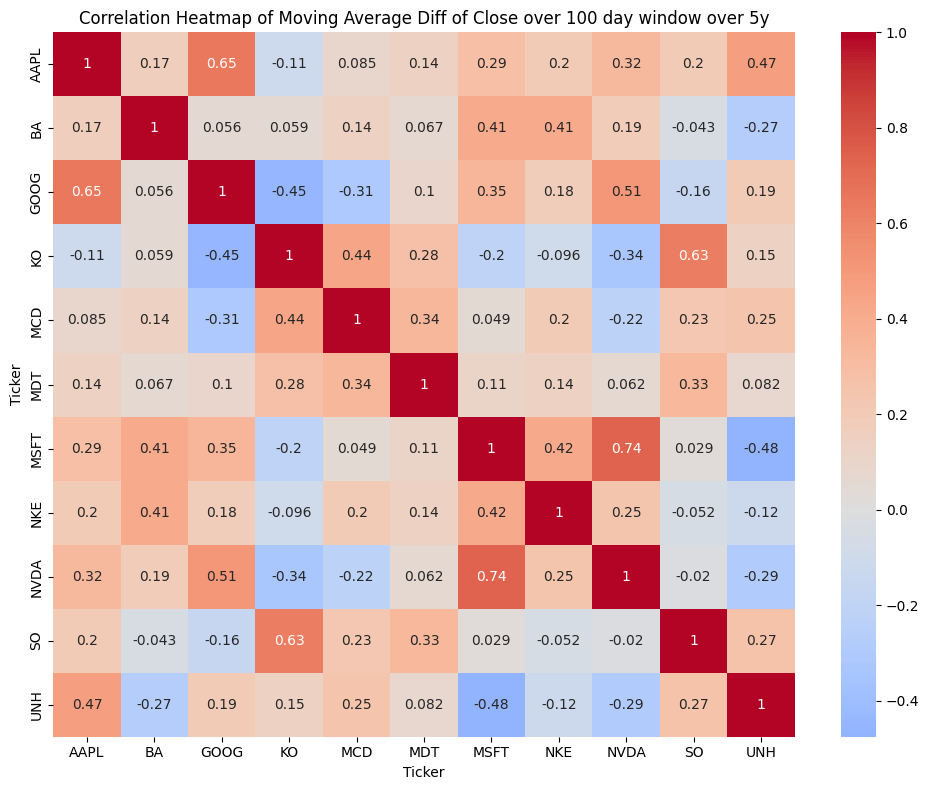

In [34]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title(f'Correlation Heatmap of Moving Average Diff of {feature} over {window} day window over {test.timePeriod}' )
plt.tight_layout()
plt.show()

In [35]:
feature = 'Volume'
returns = test.MovingAverages(feature,70)[('Diff',)]
summary_stats = returns.describe().T
summary_stats['skew'] = returns.skew()
summary_stats['kurtosis'] = returns.kurtosis()
corr_matrix = returns.corr()
cov_matrix = returns.cov()

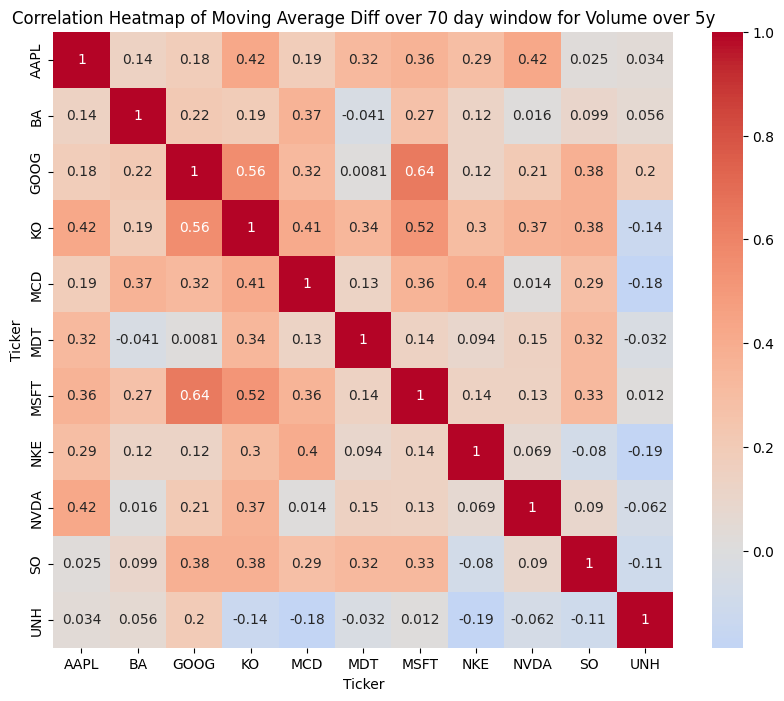

In [36]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title(f'Correlation Heatmap of Moving Average Diff over 70 day window for Volume over {test.timePeriod}' )
plt.show()

In [37]:
bigTest.change_timePeriod('5y')

[*********************100%***********************]  90 of 90 completed


In [38]:
feature = 'Close'
df = test.MovingAverages(feature,70)[('Diff',)]
fig = px.line(df, x = df.index, y = df.columns[:4], title = f'Moving Average diff over 70 day window for {feature} over {bigTest.timePeriod}')
fig.show()

In [39]:
feature = 'Volume'
df = test.MovingAverages(feature,70)[('Diff',)]
fig = px.line(df, x = df.index, y = df.columns[:4], title = f'Moving Average diff over 70 day window for {feature} over {bigTest.timePeriod}')
fig.show()

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score

In [41]:
def LinearRegModel(testDf,targetDf,ticker,targetDay):
  X_train, X_test, y_train, y_test = train_test_split(testDf, targetDf, test_size=0.2)
  standXTest,standXtrain = standardize(X_test,X_train)
  standYTest,standYtrain = standardize(y_test,y_train)
  # Initialize the model
  model = LinearRegression()
  X_train = standXtrain.sort_index()
  y_train = standYtrain.sort_index().values.ravel()
  X_test = standXTest.sort_index()
  y_test = standYTest.sort_index().values.ravel()
  # Train the model

  model.fit(X_train, y_train)

  # Predict on the test data
  y_pred = model.predict(X_test)
  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(f"For ticker: {ticker}")
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"R^2 Score: {r2:.2f}")
  standTestDf, standTargetDf = standardize(testDf,targetDf)
  allPred = model.predict(standTestDf)
  PredPriceForNextDay = allPred[len(allPred)- 1]*targetDf.std().iloc[0]+targetDf.mean().iloc[0]
  print(PredPriceForNextDay)

In [42]:
def RegTreeModel(testDf,targetDf,ticker,targetDay):
  X_train, X_test, y_train, y_test = train_test_split(testDf, targetDf, test_size=0.2)
  standXTest,standXtrain = standardize(X_test,X_train)
  standYTest,standYtrain = standardize(y_test,y_train)
  # Initialize the model
  model = RandomForestRegressor()
  # Prepare processed data for fitting and metrics
  X_train_processed = standXtrain.sort_index()
  y_train_processed = standYtrain.sort_index().values.ravel() # Convert to 1D array for fitting
  X_test_processed = standXTest.sort_index()
  y_test_processed = standYTest.sort_index().values.ravel() # Convert to 1D array for metrics

  # Train the model
  model.fit(X_train_processed, y_train_processed)

  # Predict on the test data
  y_pred = model.predict(X_test_processed)
  # Evaluate the model
  mse = mean_squared_error(y_test_processed, y_pred)
  r2 = r2_score(y_test_processed, y_pred)
  print(f"For ticker: {ticker}")
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"R^2 Score: {r2:.2f}")
  standTestDf, standTargetDf = standardize(testDf,targetDf)
  allPred = model.predict(standTestDf)
  PredPriceForNextDay = allPred[len(allPred)- 1]*targetDf.std().iloc[0]+targetDf.mean().iloc[0]
  print(PredPriceForNextDay)

In [43]:
movingAverageWindow = 7
dayshift = 1 #This is to choose which day we want to predict, we're looking at the tail
# of length dayshift of our dataframe then we choose [0]
targetFeature = 'Close'
sampleSize = 650 #randomly selecting this many days from history
DaysBack = 1 #from our target days we are looking at the history this many days back
#so for nov 30th days back would correspond with nov16th data point
print(f"Results for Linear Regression Model, \nMSE, R^2, and predicted {targetFeature} price {DaysBack} days from now\nWith Moving Avg Window of {movingAverageWindow},{movingAverageWindow*2}, and {movingAverageWindow*5} days")
for ticker in test.tickerList:
    diff = test.MovingAverages('Close',movingAverageWindow)[('Diff',ticker)].dropna()
    diffShifted2X = test.MovingAverages('Close',movingAverageWindow*2)[('Diff',ticker)].dropna()
    diffShifted5X = test.MovingAverages('Close',movingAverageWindow*5)[('Diff',ticker)].dropna()
    #volDiff = test.MovingAverages('Volume',movingAverageWindow)[('Diff',ticker)].dropna()
    logReturn = test.getLogChangeHistory('Close')[ticker].tail(len(test.data[('Close',ticker)]) - movingAverageWindow + 1).dropna()
    #volumeData = test.data[('Volume',ticker)].tail(len(test.data[('Volume',ticker)]) - movingAverageWindow + 1)
    closeData = test.data[('Close',ticker)].tail(len(test.data[('Close',ticker)]) - movingAverageWindow + 1)
    openData = test.data[('Open', ticker)].tail(len(test.data[('Open',ticker)]) - movingAverageWindow + 1)
    lowData = test.data[('Low', ticker)].tail(len(test.data[('Low',ticker)]) - movingAverageWindow + 1)
    highData = test.data[('High', ticker)].tail(len(test.data[('High',ticker)]) - movingAverageWindow + 1)
    #testDay = [diff.tail(dayshift).iloc[0],volDiff.tail(dayshift).iloc[0],logReturn.tail(dayshift).iloc[0],volumeData.tail(dayshift).iloc[0],closeData.tail(dayshift).iloc[0],openData.tail(dayshift).iloc[0],
    #           lowData.tail(dayshift).iloc[0],highData.tail(dayshift).iloc[0]]
    nonShiftedTestDf = pd.DataFrame({'LogReturn': logReturn,
                                     'MovingAvgDiffClose':diff,
                                     'Shifted2xMovingAvg':diffShifted2X,
                                     'Shifted5xMovingAvg':diffShifted5X,
                                     #'MovingAvgDiffVol': volDiff,
                                     #'Volume':volumeData,
                                     'Close':closeData,
                                     'Open':openData,
                                     'Low':lowData,
                                     'High':highData})
    testDf,targetDf = test.featureAndTargetSplitter(DaysBack, sampleSize, targetFeature,movingAverageWindow, ticker )
    #testDay = (testDay - np.array(list(nonShiftedTestDf.mean())))/np.array(list(nonShiftedTestDf.std()))
    targetDay = test.data[(targetFeature,ticker)].tail(DaysBack).iloc[0]
    LinearRegModel(testDf,targetDf,ticker,targetDay)


Results for Linear Regression Model, 
MSE, R^2, and predicted Close price 1 days from now
With Moving Avg Window of 7,14, and 35 days
For ticker: MSFT
Mean Squared Error: 0.00
R^2 Score: 1.00
490.222487747376
For ticker: AAPL
Mean Squared Error: 0.01
R^2 Score: 0.99
278.5756325777421
For ticker: GOOG
Mean Squared Error: 0.01
R^2 Score: 0.99
316.8563190083324
For ticker: UNH
Mean Squared Error: 0.01
R^2 Score: 0.99
323.21029510477115
For ticker: NVDA
Mean Squared Error: 0.00
R^2 Score: 1.00
184.1424412820165
For ticker: KO
Mean Squared Error: 0.01
R^2 Score: 0.99
70.20331674818883
For ticker: BA
Mean Squared Error: 0.02
R^2 Score: 0.98
206.07643351409345
For ticker: MDT
Mean Squared Error: 0.01
R^2 Score: 0.99
101.13547396932293
For ticker: MCD
Mean Squared Error: 0.01
R^2 Score: 0.99
310.0918729259458
For ticker: SO
Mean Squared Error: 0.01
R^2 Score: 0.99
85.63846718818549
For ticker: NKE
Mean Squared Error: 0.01
R^2 Score: 0.99
63.6252257501893


In [44]:
print(f"Results for Regression Tree Model, \nMSE, R^2, and predicted {targetFeature} price {DaysBack} days from now\nWith Moving Avg Window of {movingAverageWindow},{movingAverageWindow*2},and {movingAverageWindow*5} days")
for ticker in test.tickerList:
    diff = test.MovingAverages('Close',movingAverageWindow)[('Diff',ticker)].dropna()
    diffShifted2X = test.MovingAverages('Close',movingAverageWindow*2)[('Diff',ticker)].dropna()
    diffShifted5X = test.MovingAverages('Close',movingAverageWindow*5)[('Diff',ticker)].dropna()
    #volDiff = test.MovingAverages('Volume',movingAverageWindow)[('Diff',ticker)].dropna()
    logReturn = test.getLogChangeHistory('Close')[ticker].tail(len(test.data[('Close',ticker)]) - movingAverageWindow + 1).dropna()
    #volumeData = test.data[('Volume',ticker)].tail(len(test.data[('Volume',ticker)]) - movingAverageWindow + 1)
    closeData = test.data[('Close',ticker)].tail(len(test.data[('Close',ticker)]) - movingAverageWindow + 1)
    openData = test.data[('Open', ticker)].tail(len(test.data[('Open',ticker)]) - movingAverageWindow + 1)
    lowData = test.data[('Low', ticker)].tail(len(test.data[('Low',ticker)]) - movingAverageWindow + 1)
    highData = test.data[('High', ticker)].tail(len(test.data[('High',ticker)]) - movingAverageWindow + 1)
    #testDay = [diff.tail(dayshift).iloc[0],volDiff.tail(dayshift).iloc[0],logReturn.tail(dayshift).iloc[0],volumeData.tail(dayshift).iloc[0],closeData.tail(dayshift).iloc[0],openData.tail(dayshift).iloc[0],
    #           lowData.tail(dayshift).iloc[0],highData.tail(dayshift).iloc[0]]
    nonShiftedTestDf = pd.DataFrame({'LogReturn': logReturn,
                                     'MovingAvgDiffClose':diff,
                                     'Shifted2xMovingAvg':diffShifted2X,
                                     'Shifted5xMovingAvg':diffShifted5X,
                                     #'MovingAvgDiffVol': volDiff,
                                     #'Volume':volumeData,
                                     'Close':closeData,
                                     'Open':openData,
                                     'Low':lowData,
                                     'High':highData})
    testDf,targetDf = test.featureAndTargetSplitter(DaysBack, sampleSize, targetFeature,movingAverageWindow, ticker )
    #testDay = (testDay - np.array(list(nonShiftedTestDf.mean())))/np.array(list(nonShiftedTestDf.std()))
    targetDay = test.data[(targetFeature,ticker)].tail(DaysBack).iloc[0]
    RegTreeModel(testDf,targetDf,ticker,targetDay)

Results for Regression Tree Model, 
MSE, R^2, and predicted Close price 1 days from now
With Moving Avg Window of 7,14,and 35 days
For ticker: MSFT
Mean Squared Error: 0.01
R^2 Score: 0.99
487.27861312932845
For ticker: AAPL
Mean Squared Error: 0.01
R^2 Score: 0.99
278.13653253228273
For ticker: GOOG
Mean Squared Error: 0.01
R^2 Score: 0.99
314.3869745399393
For ticker: UNH
Mean Squared Error: 0.01
R^2 Score: 0.99
325.10555336176515
For ticker: NVDA
Mean Squared Error: 0.00
R^2 Score: 1.00
183.3312627110744
For ticker: KO
Mean Squared Error: 0.02
R^2 Score: 0.98
69.93370504187196
For ticker: BA
Mean Squared Error: 0.03
R^2 Score: 0.97
202.60287991372888
For ticker: MDT
Mean Squared Error: 0.01
R^2 Score: 0.99
101.36006657187052
For ticker: MCD
Mean Squared Error: 0.02
R^2 Score: 0.98
309.9088625510071
For ticker: SO
Mean Squared Error: 0.01
R^2 Score: 0.99
85.60101136117434
For ticker: NKE
Mean Squared Error: 0.01
R^2 Score: 0.99
62.72782249569282


In [45]:
ticker = 'NVDA'
diff = test.MovingAverages('Close',movingAverageWindow)[('Diff',ticker)].dropna()
diffShifted2X = test.MovingAverages('Close',movingAverageWindow*2)[('Diff',ticker)].dropna()
diffShifted5X = test.MovingAverages('Close',movingAverageWindow*5)[('Diff',ticker)].dropna()
#volDiff = test.MovingAverages('Volume',movingAverageWindow)[('Diff',ticker)].dropna()
logReturn = test.getLogChangeHistory('Close')[ticker].tail(len(test.data[('Close',ticker)]) - movingAverageWindow + 1).dropna()
#volumeData = test.data[('Volume',ticker)].tail(len(test.data[('Volume',ticker)]) - movingAverageWindow + 1)
closeData = test.data[('Close',ticker)].tail(len(test.data[('Close',ticker)]) - movingAverageWindow + 1)
openData = test.data[('Open', ticker)].tail(len(test.data[('Open',ticker)]) - movingAverageWindow + 1)
lowData = test.data[('Low', ticker)].tail(len(test.data[('Low',ticker)]) - movingAverageWindow + 1)
highData = test.data[('High', ticker)].tail(len(test.data[('High',ticker)]) - movingAverageWindow + 1)
#testDay = [diff.tail(dayshift).iloc[0],volDiff.tail(dayshift).iloc[0],logReturn.tail(dayshift).iloc[0],volumeData.tail(dayshift).iloc[0],closeData.tail(dayshift).iloc[0],openData.tail(dayshift).iloc[0],
#           lowData.tail(dayshift).iloc[0],highData.tail(dayshift).iloc[0]]
nonShiftedTestDf = pd.DataFrame({'LogReturn': logReturn,
                                  'MovingAvgDiffClose':diff,
                                  'Window2xMovingAvg':diffShifted2X,
                                  'Window5xMovingAvg':diffShifted5X,
                                  #'MovingAvgDiffVol': volDiff,
                                  #'Volume':volumeData,
                                  'Close':closeData,
                                  'Open':openData,
                                  'Low':lowData,
                                  'High':highData})
nonShiftedTestDf

,LogReturn,MovingAvgDiffClose,Window2xMovingAvg,Window5xMovingAvg,Close,Open,Low,High
Date,,,,,,,,
2020-12-21,0.004529,-0.010396,NaN,NaN,13.332250,13.074750,12.967500,13.370000
2020-12-22,-0.004059,-0.042895,NaN,NaN,13.278250,13.319250,13.054000,13.337250
2020-12-23,-0.020467,-0.063341,NaN,NaN,13.009250,13.256000,13.005000,13.275000
2020-12-24,-0.001192,-0.062247,NaN,NaN,12.993750,13.037250,12.938750,13.132500
2020-12-28,-0.007241,-0.075230,NaN,NaN,12.900000,13.062500,12.763250,13.062500
...,...,...,...,...,...,...,...,...
2025-12-04,0.020884,1.239600,0.811862,-2.970407,183.380005,181.619995,179.960007,184.520004
2025-12-05,-0.005304,0.896844,1.330185,-3.130702,182.410004,183.889999,180.910004,184.660004
2025-12-08,0.017067,1.160847,1.792684,-3.158028,185.550003,182.639999,182.399994,188.000000


# Alex Stuff

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import os
import yfinance as yf
from fredapi import Fred
fred = Fred(api_key='a99f8e0301913988401acd5680bd2c05')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

ModuleNotFoundError: No module named 'fredapi'

In [ ]:
class Economic_Data():

    def __init__(self):
        self.fedTrate = self.get_fed_target_rate()
        self.UnempRate = self.get_unemployment_rate()
        self.gdp = self.get_gdp()
        self.cpi = self.get_CPI()
        self.baseReturnR = self.base_return_rate() #This benchmark will be used at the end, to make sure expected returns are enough
        self.cci = self.consumer_confidence_index()
        self.merged_data_df = self.merged_data_df()

        #_________________

    def calculate_momentum(self, data_column, lookback=3, rate_lookback=6):
        #A helper function to see if rates/economic attributes are rising or falling to calculate current economic cycle period
        if data_column.name in ['Avg', 'Risk Free Returns']: #Used longer lookback for rates
            lookback = rate_lookback

        #Case 0: We get a column for the pandas dataframe (pandas series) that does not have enough data:
        if len(data_column) < lookback + 1:
            return "Stable"

        current_value = data_column.iloc[-1]

        #Calculate the average of the previous 'lookback' periods
        lookback_average = data_column.iloc[-lookback-1:-1].mean()

        #Threshold that reveals if change is great enough to show a change in economic trend
        threshold = 0.025

        if current_value > lookback_average + threshold:
            return "Rising"
        elif current_value < lookback_average - threshold:
            return "Falling"
        else:
            return "Stable"

            #_________________

    def get_fed_target_rate(self): #gets federal target rate which is calculated daily
        upper = fred.get_series('DFEDTARU', observation_start = '2018-01-01')
        lower = fred.get_series('DFEDTARL', observation_start = '2018-01-01')
        # Combine into one DataFrame
        rates = pd.DataFrame({'Upper': upper, 'Lower': lower})
        rates = rates.dropna()
        #Make a column with the average rate
        rates["Avg"] = (rates["Upper"] + rates["Lower"])/2
        rates.index.name = 'Date'

        #rates['Rates_Momentum'] = rates['Avg'].apply(lambda x: self.calculate_momentum(rates['Avg'], rate_lookback=6))

        #original plot to see how the rates have changed throughout the years
        # rates.plot(title='Federal Funds Target Range (Upper & Lower Limits)')
        # plt.show()

        return rates[["Avg"]]

        #_________________

    def get_unemployment_rate(self): #get unemployment rate calculated monthly
        UR = fred.get_series('UNRATE', observation_start='2018-01-01')
        # Convert to DataFrame
        UR_df = pd.DataFrame(UR)
        UR_df = UR_df.dropna()
        UR_df = UR_df.rename(columns = {0:"Unemployment Rate"})
        UR_df.index.name = 'Date'
        #UR_df['Unemp_Momentum'] = UR_df['Unemployment Rate'].apply(lambda x: self.calculate_momentum(UR_df['Unemployment Rate']))

        return UR_df

        #_________________

    def get_gdp(self): #this gets the real gdp which is calculated quarterly
        gdp = fred.get_series('GDPC1', observation_start='2018-01-01')
        # Convert to DataFrame
        gdp_df = pd.DataFrame(gdp) #this comes out in the tens of thousands
        gdp_df = gdp_df.dropna()
        gdp_df.rename(columns={0: 'Real-GDP/1,000,000'}, inplace=True)

        gdp_df["Annual Growth"] = gdp_df['Real-GDP/1,000,000'].pct_change(periods=4) *100
        gdp_df = gdp_df.dropna()
        gdp_df.index.name = 'Date'

        #gdp_df['GDP_Momentum'] = gdp_df['Annual Growth'].apply(lambda x: self.calculate_momentum(gdp_df['Annual Growth']))

        return gdp_df[["Annual Growth"]]

        #_________________

    def get_CPI(self): #gets consumer price index which is calculated monthly, and calculates the annual inflation rate
        data = fred.get_series('CPIAUCSL', observation_start='2018-01-01')
        # Convert to DataFrame
        cpi_data = pd.DataFrame(data)
        cpi_data = cpi_data.dropna()
        cpi_data.rename(columns={0: 'Consumer Price Index'}, inplace=True)
        cpi_data.index.name = 'Date'
        cpi_data["Inflation Rate"] = cpi_data["Consumer Price Index"].pct_change(periods = 12) *100
        cpi_data = cpi_data.dropna()

        #cpi_data['CPI_Momentum'] = cpi_data['Inflation Rate'].apply(lambda x: self.calculate_momentum(cpi_data['Inflation Rate']))

        return cpi_data[["Inflation Rate"]]

        #_________________

    def base_return_rate(self): #the rate of return of risk free treasury bonds, ie the benchmark we must beat
        treasury_yields = fred.get_series('DGS10', observation_start='2018-01-01')
        # Convert to DataFrame
        ty = pd.DataFrame(treasury_yields)
        ty = ty.dropna()
        ty.rename(columns={0: 'Risk Free Returns'}, inplace=True)
        ty.index.name = 'Date'
        return ty

        #_________________

    def consumer_confidence_index(self): #calculates the consumer confidence index on the economy -100/+100 range
        cci = fred.get_series('CSCICP03USM665S', observation_start='2008-01-01')

        # Convert to DataFrame
        CCI_df = pd.DataFrame(cci, columns=['Consumer Confidence Index'])
        CCI_df = CCI_df.dropna()
        CCI_df.index.name = 'Date'

        return CCI_df


        #_________________

    def cycle_classification_byrow(row):
        """
        Classifies the current economic cycle (Boom, Recession, Recovery, Stagflation)
        based on the latest macroeconomic data and defined thresholds.
        """
        # GDP growth Thresholds
        high_gdp = 2.5   # strong expansion
        low_gdp = 1.0    # weak growth
        recession = 0.0  # contraction

        # Unemployment Thresholds
        high_une = 6.0
        low_une = 4.0

        # Inflation Thresholds
        high_inflation = 3.0     # above Fed target meaningfully
        moderate_inflation = 1.5 # typical level
        low_inflation = 0.5

        #Fed Rate Thresholds
        high_fed_rate = 3.0
        low_fed_rate = 1.5



        #Get the momentum for each row
        latest_gdp_growth = row['Annual Growth']
        gdp_momentum = row['GDP_mom']

        latest_unemployment = row['Unemployment Rate']
        unemp_momentum = row['Unemp_mom']

        latest_inflation = row['Inflation Rate']
        inflation_momentum = row['cpi_mom']

        latest_fed_rate = row['Avg']
        rate_momentum = row['ftr_mom']

        #set current economic cycle state to unknown
        current_cycle = "Unknown"


        #1. RECESSION/CONTRACTION: Negative growth and rising unemployment
        # if (latest_gdp_growth <= recession or gdp_momentum == "Falling") and unemp_momentum == "Rising":
        #     current_cycle = "Recession/Contraction"

        if latest_gdp_growth <= recession or \
           (gdp_momentum == "Falling" and unemp_momentum == "Rising"):
            current_cycle = "Recession/Contraction"

        #2. STAGFLATION: Low Growth, High Unemployment, High Inflation
        elif latest_gdp_growth <= low_gdp and \
             latest_unemployment >= high_une and \
             latest_inflation >= high_inflation:
            current_cycle = "Stagflation"

        #3. BOOM/LATE CYCLE: High Growth, Low Unemployment, Rising Inflation/Rates
        # elif latest_gdp_growth >= high_gdp and \
        #      latest_unemployment <= low_une and \
        #      (inflation_momentum == "Rising" or rate_momentum == "Rising"):
        #     current_cycle = "Boom/Late Cycle"
        elif latest_gdp_growth >= high_gdp and \
             latest_unemployment <= low_une and \
             (latest_inflation >= moderate_inflation or inflation_momentum == "Rising"):
            current_cycle = "Boom/Late Cycle"

        #4. RECOVERY/EARLY CYCLE: Positive/Rising Growth, Falling Unemployment, Low/Stable Inflation
        # elif gdp_momentum == "Rising" and \
        #      unemp_momentum == "Falling" and \
        #      (latest_inflation >= low_inflation_mean and latest_inflation <= low_inflation_max) and \
        #      latest_fed_rate <= low_fed_rate:
        #     current_cycle = "Recovery/Early Cycle"
        elif latest_gdp_growth > 0 and \
             gdp_momentum == "Rising" and \
             unemp_momentum == "Falling" and \
             inflation_momentum != "Rising":   # stable or falling inflation typical
            current_cycle = "Recovery/Early Cycle"


        # 5. Default/Stable (Catch-all for periods not clearly defined above)
        else:
            current_cycle = "Stable/Mid-Cycle"

        return current_cycle

        #_________________


    #creates the mega dataframe we will use to train the machine learning model:
    def merged_data_df(self):
        macro_data_dfs = [self.fedTrate, self.UnempRate, self.gdp, self.cpi, self.baseReturnR, self.cci]

        merge_df = pd.DataFrame(index = self.UnempRate.index)
        for dataframe in macro_data_dfs:
            merge_df = merge_df.join(dataframe, how = "outer")

        merge_df = merge_df.ffill()
        merge_df = merge_df.dropna()

        #Calculate the momentum of economic data to find trends and classify the economic cycle:
        #Make new columns with the averages of each data to find the baseline:
        merge_df['avg_gdp'] = merge_df["Annual Growth"].shift(1).rolling(3).mean()       #Shifting by one ensure we don't get
        merge_df['avg_unemp'] = merge_df["Unemployment Rate"].shift(1).rolling(3).mean() #bias on future data
        merge_df['avg_cpi'] = merge_df["Inflation Rate"].shift(1).rolling(3).mean()
        merge_df['avg_rates'] = merge_df["Avg"].shift(1).rolling(6).mean()

        #Momentum Threshold:
        mom_threshold = 0.015

        #GDP:
        merge_df["GDP_mom"] = merge_df.apply(lambda row:
                                             "Rising" if row ['Annual Growth'] > row['avg_gdp'] + mom_threshold else
                                            ('Falling' if row['Annual Growth'] < row['avg_gdp'] - mom_threshold else 'steady'), axis = 1)

        #Unemployment rate:
        merge_df["Unemp_mom"] = merge_df.apply(lambda row:
                                             "Rising" if row ['Unemployment Rate'] > row['avg_unemp'] + mom_threshold else
                                            ('Falling' if row['Unemployment Rate'] < row['avg_unemp'] - mom_threshold else 'steady'), axis = 1)

        #CPI:
        merge_df["cpi_mom"] = merge_df.apply(lambda row:
                                             "Rising" if row ["Inflation Rate"] > row['avg_cpi'] + mom_threshold else
                                            ('Falling' if row["Inflation Rate"] < row['avg_cpi'] - mom_threshold else 'steady'), axis = 1)

        #Federal Target Rates:
        merge_df["ftr_mom"] = merge_df.apply(lambda row:
                                             "Rising" if row ['Avg'] > row['avg_rates'] + mom_threshold else
                                            ('Falling' if row['Avg'] < row['avg_rates'] - mom_threshold else 'steady'), axis = 1)

        merge_df = merge_df.dropna()

        merge_df['Economic_State'] = merge_df.apply(Economic_Data.cycle_classification_byrow, axis = 1)
        merge_df.index.name = "Date"

        #delete unnecessary columns from the dataframe:
        drop_cols = [col for col in merge_df.columns if "_Avg" in col or "Real-GDP/1,000,000" in col or "Consumer Price Index" in col]
        drop_cols2 = ["avg_gdp", "avg_unemp", "avg_cpi", "avg_rates", "GDP_mom", "Unemp_mom", "cpi_mom", "ftr_mom"]

        merge_df = merge_df.drop(columns = drop_cols)
        merge_df = merge_df.drop(columns = drop_cols2)


        return merge_df

        #_________________

    def determine_current_cycle(self):
        """Returns the classified cycle for the latest available date."""
        if not self.merged_data_df.empty:
            return self.merged_data_df['Economic_State'].iloc[-1]
        return "Data Not Loaded"

In [ ]:
def next_return_col(ticker):
    """Canonical name for 'next month return' target column."""
    return f"{ticker}_NextReturn"


class PortfolioDataProcessor:
    """
    Downloads monthly-adjusted prices, computes monthly returns (pct * 100),
    merges with macro data and produces a final training dataframe.
    """
    def __init__(self, tickers, macro_data_instance):
        self.tickers = tickers
        self.macro_df = macro_data_instance.merged_data_df.copy()
        self.all_returns_df = self.get_stock_returns()
        self.final_training_df = self.merge_macro_and_market_data()

    def get_stock_returns(self):
        print(f"Downloading data for tickers: {self.tickers}...")
        start_date = self.macro_df.index.min().strftime('%Y-%m-%d')
        try:
            raw_data = yf.download(self.tickers, start=start_date, progress=False, auto_adjust=False)
            if raw_data.empty:
                raise ValueError("yfinance returned empty DataFrame.")
            # Extract Adj Close robustly
            if len(self.tickers) == 1:
                if 'Adj Close' in raw_data.columns:
                    prices = raw_data[['Adj Close']].rename(columns={'Adj Close': self.tickers[0]})
                elif 'Close' in raw_data.columns:
                    prices = raw_data[['Close']].rename(columns={'Close': self.tickers[0]})
                else:
                    raise KeyError("Could not find price columns.")
            else:
                # MultiIndex: level 0=field, level1=ticker; we want 'Adj Close' row
                if 'Adj Close' in raw_data.columns.get_level_values(0):
                    prices = raw_data.xs('Adj Close', axis=1, level=0)
                else:
                    # fallback to Close
                    prices = raw_data.xs('Close', axis=1, level=0)
            prices = prices.dropna(axis=1, how='all')
            if prices.empty:
                raise ValueError("All tickers dropped due to NaNs.")
        except Exception as e:
            print("Error downloading price data:", e)
            return pd.DataFrame()

        # Resample to month end and compute percent returns
        monthly_prices = prices.resample('ME').last()
        monthly_returns = monthly_prices.pct_change() * 100.0
        # standardize column names to e.g., 'SPY_Return'
        monthly_returns.columns = [f"{col}_Return" for col in monthly_returns.columns]
        monthly_returns = monthly_returns.dropna()
        print("Monthly stock returns calculated.")
        return monthly_returns

    def merge_macro_and_market_data(self):
        if self.all_returns_df.empty or self.macro_df.empty:
            print("Cannot merge: stock or macro data empty.")
            return pd.DataFrame()
        # Align indexes and join inner (only months where both exist)
        macro = self.macro_df.copy()
        # ONE-HOT encode 'Economic_State' deterministically here so everyone uses same columns
        if 'Economic_State' in macro.columns:
            macro = pd.get_dummies(macro, columns=['Economic_State'], prefix='Cycle')
        final_df = macro.join(self.all_returns_df, how='inner')
        final_df = final_df.dropna()  # drop any remaining NaNs
        print(f"Data merged. final df shape: {final_df.shape}")
        return final_df

In [ ]:

def evaluate_model(model_pipeline, df, ticker, feature_cols, eval_mode='in_sample'):
    """
    model_pipeline: sklearn Pipeline or estimator supporting .predict(X)
    eval_mode: 'in_sample' will compare model.predict(X) to X's {ticker}_Return
               'one_step' will compare model trained on X[:-1] predicting next row to actual next row.
               (This function does NOT retrain the model; it's for quick diagnostic plots.)
    """
    # Ensure economic state is encoded (should already be from processor, but safe)
    if 'Economic_State' in df.columns:
        df = pd.get_dummies(df, columns=['Economic_State'], prefix='Cycle')

    if eval_mode == 'in_sample':
        target_col = f"{ticker}_Return"
        if target_col not in df.columns:
            print(f"{target_col} missing in df.")
            return None
        X = df[feature_cols]
        y = df[target_col]
        y_pred = model_pipeline.predict(X)
    elif eval_mode == 'one_step':
        # Build one-step-ahead prediction using the pipeline as-is (no retrain)
        # This expects the pipeline is already trained on appropriate data outside.
        # We predict X.iloc[:-1] -> compare to y.iloc[1:]
        target_col = f"{ticker}_Return"
        if target_col not in df.columns or len(df) < 3:
            print("Not enough data or missing target for one-step evaluation.")
            return None
        X = df[feature_cols]
        y = df[target_col]
        y_pred = model_pipeline.predict(X.iloc[:-1])
        y = y.iloc[1:]  # alignment: prediction for next period
        # align indices
        y_pred = pd.Series(y_pred, index=y.index)
    else:
        raise ValueError("eval_mode must be 'in_sample' or 'one_step'")

    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    print(f"{ticker} | eval_mode={eval_mode} | R2={r2:.4f} | MSE={mse:.4f}")

    plt.figure(figsize=(12,5))
    plt.plot(y.index, y, label='Actual', marker='o')
    plt.plot(y.index, y_pred, label='Predicted', linestyle='--', marker='x')
    plt.title(f"{ticker} Actual vs Predicted Returns ({eval_mode})")
    plt.ylabel("Return (%)")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.show()

    residuals = y - y_pred
    plt.figure(figsize=(12,4))
    plt.plot(y.index, residuals, marker='o')
    plt.axhline(0, linestyle='--')
    plt.title(f"{ticker} Residuals ({eval_mode})")
    plt.ylabel("Error (%)")
    plt.xlabel("Date")
    plt.grid(True)
    plt.show()

    return mse, r2

In [ ]:
def measure_forecast_accuracy(tickers, lookback_years=2, base_model_params=None):
    """
    Proper walk-forward validation:
    - At each step t, train on data up to t, predict t+1, append result.
    - Uses Pipeline(StandardScaler, RandomForestRegressor).
    Returns results_df with Predicted and Actual returns + Correct_Direction.
    """
    if base_model_params is None:
        base_model_params = {'n_estimators': 200, 'max_depth': 5, 'random_state': 42}

    macro_data = Economic_Data()
    processor = PortfolioDataProcessor(tickers, macro_data)
    df = processor.final_training_df.copy()
    if df.empty:
        print("No data available.")
        return pd.DataFrame()

    # Ensure Economic_State columns are one-hot encoded already from processor
    # Feature columns: everything that is not a ticker return
    # Use columns that don't end with '_Return'
    feature_cols = [c for c in df.columns if not c.endswith('_Return')]

    months_to_test = lookback_years * 12
    start_index = len(df) - months_to_test
    if start_index < 24:
        start_index = 24  # require at least 2 years to train initially

    results = []
    for i in range(start_index, len(df) - 1):
        train_df = df.iloc[:i+1].copy()  # up to t
        predict_row = df.iloc[[i+1]].copy()  # row for t+1 (to compare)
        for ticker in tickers:
            # Prepare training target: shifted next-return
            target = next_return_col(ticker)  # canonical name

            train_df[target] = train_df[f"{ticker}_Return"].shift(-1)
            #tried to et weekly results and failed terribly.
            #its best to stick with monthly predictions since we want investors to be comfortable in the long run
            #train_df[target] = train_df[f"{ticker}_Return"].pct_change(5)

            # drop last row in train_df because we don't know its next value
            train_clean = train_df.iloc[:-1].dropna(subset=[target])
            if train_clean.empty:
                continue
            X_train = train_clean[feature_cols]
            y_train = train_clean[target]
            # Build pipeline (scaler + regressor)
            pipe = Pipeline([
                ('scaler', StandardScaler()),
                ('rf', RandomForestRegressor(**base_model_params))
            ])
            pipe.fit(X_train, y_train)
            # Predict using only the latest available macro features (time t)
            X_pred = train_df[feature_cols].iloc[[-1]]
            pred = pipe.predict(X_pred)[0]
            actual = predict_row[f"{ticker}_Return"].values[0]
            results.append({
                'Date': df.index[i+1],
                'Ticker': ticker,
                'Predicted': pred,
                'Actual': actual,
                'Correct_Direction': (pred > 0) == (actual > 0)
            })
    results_df = pd.DataFrame(results)
    if results_df.empty:
        print("No forecasts generated.")
        return results_df

    dir_acc = results_df['Correct_Direction'].mean() * 100
    mae = mean_absolute_error(results_df['Actual'], results_df['Predicted'])
    print(f"Directional Accuracy: {dir_acc:.2f}%")
    print(f"MAE: {mae:.4f}%")

    # Per-ticker summary
    summary = results_df.groupby('Ticker').apply(lambda x: pd.Series({
        'Directional Acc (%)': x['Correct_Direction'].mean() * 100,
        'Avg Error (%)': mean_absolute_error(x['Actual'], x['Predicted'])
    }))
    display(summary)

    # Scatter plot
    plt.figure(figsize=(10,6))
    colors = ['green' if v else 'red' for v in results_df['Correct_Direction']]
    plt.scatter(results_df['Actual'], results_df['Predicted'], c=colors, alpha=0.6)
    lim = max(abs(results_df['Actual']).max(), abs(results_df['Predicted']).max()) * 1.1
    plt.plot([-lim, lim], [-lim, lim], 'k--', alpha=0.6)
    plt.axhline(0, color='gray')
    plt.axvline(0, color='gray')
    plt.xlabel('Actual Return (%)')
    plt.ylabel('Predicted Return (%)')
    plt.title('Walk-forward: Predicted vs Actual Returns')
    plt.grid(True, alpha=0.3)
    plt.show()

    return results_df

In [ ]:
def predict_and_allocate(tickers, initial_capital, min_pred_threshold=0.25, base_model_params=None):
    """
    Trains a pipeline for each ticker on all available history (chronological),
    predicts the next month's return using the *latest macro row only* (no leakage),
    and allocates capital proportionally across tickers with positive predicted returns.
    Params:
        min_pred_threshold: percent return threshold (in same units as returns) under which we treat prediction as zero
    """
    if base_model_params is None:
        base_model_params = {'n_estimators': 200, 'max_depth': 5, 'random_state': 42}
    print(f"--- Allocation for ${initial_capital:,.2f} ---")

    macro_data = Economic_Data()
    processor = PortfolioDataProcessor(tickers, macro_data)
    df = processor.final_training_df.copy()
    if df.empty:
        print("No data.")
        return pd.DataFrame()

    feature_cols = [c for c in df.columns if not c.endswith('_Return')]  # already encoded by processor

    # Use the last available row for macro features (this is time T)
    latest_macro = df[feature_cols].iloc[[-1]]

    predictions = {}
    pipelines = {}

    for ticker in tickers:
        # Create consistent training target (next-month return)
        target = next_return_col(ticker)
        temp = df.copy()
        temp[target] = temp[f"{ticker}_Return"].shift(-1)
        #tried to do weekly but failed
        #temp[target] = temp[f"{ticker}_WeeklyReturn"].shift(-1)
        train = temp.dropna(subset=[target]).copy()
        if train.empty:
            predictions[ticker] = 0.0
            continue

        X = train[feature_cols]
        y = train[target]

        pipe = Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestRegressor(**base_model_params))
        ])
        pipe.fit(X, y)
        pipelines[ticker] = pipe

        pred = pipe.predict(latest_macro)[0]

        # threshold tiny predictions to avoid over-trading on noise
        if abs(pred) < min_pred_threshold:
            pred = 0.0

        predictions[ticker] = pred

    # Fetch current prices safely
    current_prices = {}
    for t in tickers:
        try:
            d = yf.download(t, period="7d", progress=False, auto_adjust=False)
            if not d.empty:
                # Prefer Adj Close if available
                if isinstance(d.columns, pd.MultiIndex):
                    # get latest Adj Close for ticker if multiindex
                    if 'Adj Close' in d.columns.get_level_values(0):
                        prices = d.xs('Adj Close', axis=1, level=0)
                        price = prices.iloc[-1].iloc[0] if prices.shape[1] >= 1 else prices.iloc[-1].iat[0]
                    else:
                        price = d['Close'].iloc[-1]
                else:
                    price = d['Adj Close'].iloc[-1] if 'Adj Close' in d.columns else d['Close'].iloc[-1]
                current_prices[t] = float(price)
            else:
                current_prices[t] = 0.0
        except Exception:
            current_prices[t] = 0.0

    # Allocation: only invest in tickers with positive predicted returns
    pos_preds = {k: v for k, v in predictions.items() if v > 0}
    total_pos = sum(pos_preds.values())

    allocation_plan = []
    if total_pos == 0:
        print("No positive predictions above threshold. Hold cash (no allocation).")
    else:
        for t in tickers:
            curr_price = current_prices.get(t, 0.0)
            pred = predictions.get(t, 0.0)
            if pred > 0 and curr_price > 0:
                weight = pred / total_pos
                cash = initial_capital * weight
                shares = np.floor(cash / curr_price)  # integer shares
                invest_amt = shares * curr_price
                allocation_plan.append({
                    'Ticker': t,
                    'Current Price': curr_price,
                    'Pred. Return (%)': pred,
                    'Allocation %': weight * 100.0,
                    'Cash to Invest': invest_amt,
                    'Shares': shares
                })
            else:
                allocation_plan.append({
                    'Ticker': t,
                    'Current Price': curr_price,
                    'Pred. Return (%)': pred,
                    'Allocation %': 0.0,
                    'Cash to Invest': 0.0,
                    'Shares': 0.0
                })

    results_df = pd.DataFrame(allocation_plan).sort_values('Pred. Return (%)', ascending=False)
    return results_df

In [ ]:
tickers = ['SPY', 'QQQ', 'IWM', "SPY", "AAPL", "MSFT", "GOOGL", "TSLA", "JNJ",'COKE', 'JPM', 'NVDA', 'TGT', 'NKE', 'UNH']
initial_capital = 10000

# Walk-forward performance
results = measure_forecast_accuracy(tickers, lookback_years=1)

# Get allocation based on latest data
alloc = predict_and_allocate(tickers, initial_capital)
display(alloc)

NameError: name 'measure_forecast_accuracy' is not defined

In [ ]:
def read_holdings_csv_with_total(file_path):
    # Read CSV file
    df = pd.read_csv(file_path)

    # Drop rows where 'Ticker Symbol' is missing
    df = df.dropna(subset=['Ticker Symbol'])

    # Convert 'Holding' to numeric, coercing errors
    df['Holding'] = pd.to_numeric(df['Holding'], errors='coerce')

    # Drop rows with NaN in 'Holding' after conversion
    df = df.dropna(subset=['Holding'])

    # Reset index
    df = df.reset_index(drop=True)

    # Calculate total holdings
    total_holdings = df['Holding'].sum()

    return df, total_holdings

In [ ]:
csv_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSVMSgdtVWfNzOXeaok8xytcGMXRyZWhB-75jP-EHIBLp3BwxFZ3TLTO_74y0dbMmCqCi9kOm5auDoX/pub?gid=0&single=true&output=csv'
df , total = read_holdings_csv_with_total(csv_url)
test4 = StockPortfolio(list(df['Ticker Symbol'].values))

[*********************100%***********************]  6 of 6 completed


In [ ]:
feature = 'Close'
window = 14
df = test4.MovingAverages(feature,window)[('Diff',)]
fig = px.line(df, x = df.index, y = df.columns[:5], title = f'Moving Average diff over {window} day window for {feature} over {test4.timePeriod}')
fig.show()

# Stuff Produced by Gemini, make sure to run the correct Stockportfolio class
## Modified featureAndTargetSplitter_KDays

### Subtask:
Inserts a new code cell with the `featureAndTargetSplitter_KDays` function. This function is a modified version of your original `featureAndTargetSplitter`. It now takes an additional parameter, `k_days_lookback`, to specify how many previous days' data should be included as features. It creates lagged versions of each financial metric (LogReturn, MovingAvgDiffClose, etc.) and combines them into a single wide feature DataFrame.


**Reasoning**:
The subtask requires replacing the existing `StockPortfolio` class with an updated version that includes the `featureAndTargetSplitter_KDays` method. This method will generate lagged features for a specified number of days.



In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf  # to fetch historical price data
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from sklearn.decomposition import PCA
# Step 1: Data Collection
import yfinance as yf
class StockPortfolio:
    '''
    This class is to help us manage data regarding a given list of stock tickers
    tickList: list or string of our stock tickers
    tickerList: Dictionary of our ticker names with the yf ticker object
    timePeriod: how far we want to look back on historical data,  must be one of: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max ,,, defaulting to 1 year
    data: A dataframe provided by yahoo finance api that gives us the daily open, close, adjusted close prices, highs and lows, and trading volume
            information for our tickers during a specified time period
    '''
    def __init__(self, tickList):
        self.tickerList = yf.Tickers(tickList).tickers
        self.timePeriod = '1y'
        self.data = yf.download(list(self.tickerList.keys()), period = self.timePeriod, auto_adjust = False) #tickers.tickers is a dictionary of yf ticker objects with keys being the ticker names
    def getSimpleChangeHistory(self, feature: str) -> pd.DataFrame:
        '''
        feature is what feature we want to see the % change in for that day, eg Close Price, Volume, Open Price
        This method calculates the daily closing price pct changes,
        calculated by taking the difference between the kth and (k-1)th day's non-adjusted closing price
        then dividing this difference by the (k-1)th close price to find the pct change after the kth day's market close
        '''
        #data = yf.download(list(self.YfTickers.keys()), period = timePeriod, auto_adjust = False) #tickers.tickers is a dictionary of yf ticker objects with keys being the ticker names
        self.simpleReturn = self.data[(feature,)].pct_change().dropna()
        return self.simpleReturn
    def getLogChangeHistory(self, feature: str) -> pd.DataFrame:
        '''
        This Method calculates the log return for each day, ln(Close Price of Today/close price of yesterday)
        '''
        self.logReturn = np.log(self.data[(feature,)]) - np.log(self.data[(feature,)].shift(1))
        return self.logReturn.dropna()
    def change_timePeriod(self, newTimePeriod: str) -> None:
        '''
        This method changes the time period for the historical data we want to look at
        '''
        self.timePeriod = newTimePeriod
        self.data = yf.download(list(self.tickerList.keys()), period = self.timePeriod, auto_adjust = False) #tickers.tickers is a dictionary of yf ticker objects with keys being the ticker names
        '''
    def simpleReturnVolatility(self) -> float:
        We Actually don't need this
        mean = self.getSimpleReturnHistory().mean()
        std = self.getSimpleReturnHistory().std()
        return std
    def logReturnVolatility(self) -> float:
        I don't think we need this either
        mean = self.getLogReturnHistory().mean()
        std = self.getLogReturnHistory().std()
        return std
        '''
    def simpleMovingAverage(self,  feature: str, dayWindow: int) -> pd.DataFrame:
        '''
        This method calculates the Simple Moving Average for a specific time window of our non-adjusted Close Prices
        '''
        return self.data[(feature, )].rolling(window = dayWindow).mean()
    def exponentialMovingAverage(self, feature: str, dayWindow: int) -> pd.DataFrame:
        '''
        feature: Any of the features of our stock data, examples: Volume Close Price

        This method calculates the exponential moving average for a specific time window of our non-adjusted Close Prices
        This one is more weighted by recent prices, so looking at the difference between the Simple Moving and Exponential moving
        can give some insight into the momentum of the price changes
        '''
        return self.data[(feature, )].ewm(span=dayWindow, adjust=False).mean()
    def extractColumns(self, cols:list,tick:list)->pd.DataFrame:
        newData = self.data.loc[:, (cols, tick)]
        return newData
    def plotMovingAveragesDiff(self,feature: str, timeWindow: int, ticker: str) -> go.Figure:
        '''
        This method creates a figure displaying the moving averages and their difference for a desired time window and ticker
        '''
        df1 = self.simpleMovingAverage(feature,timeWindow)
        df2 = self.exponentialMovingAverage(feature,timeWindow)
        df3 = self.exponentialMovingAverage(feature,timeWindow) - self.simpleMovingAverage(feature,timeWindow)
        newDf = pd.DataFrame()
        newDf['SMA'] = df1[ticker]
        newDf['EMA'] = df2[ticker]
        newDf['Diff'] = df3[ticker]
        fig = go.Figure()

        # Add SMA trace (primary y-axis)
        fig.add_trace(go.Scatter(x=newDf.index, y=newDf['SMA'], mode='lines', name='SMA'))

        # Add EMA trace (primary y-axis)
        fig.add_trace(go.Scatter(x=newDf.index, y=newDf['EMA'], mode='lines', name='EMA'))

        # Add Difference trace (secondary y-axis)
        fig.add_trace(go.Scatter(x=newDf.index, y=newDf['Diff'], mode='lines', name='Difference', yaxis='y2'))

        # Update layout for two y-axes
        diff_min = newDf['Diff'].min()
        diff_max = newDf['Diff'].max()
        padding = (diff_max - diff_min) * 0.1  # 10% padding
        fig.update_layout(
            title=f"Simple Moving Average and Exponential Moving Average of {ticker}'s {feature} over {timeWindow} day window, and Their Difference with Dual Y-Axis for {ticker}",
            xaxis=dict(title='Date'),
            yaxis=dict(title='SMA and EMA'),
            yaxis2=dict(
                title='Difference',
                overlaying='y',
                side='right',
                showgrid=False,
                zeroline=True,
                zerolinecolor='gray',
                range=[diff_min - padding, diff_max + padding]
            ),
            legend=dict(x=0, y=-1)
        )
        return fig
    def MovingAverages(self, feature: str, timeWindow: int) -> pd.DataFrame:
        df1 = self.simpleMovingAverage(feature,timeWindow)
        df2 = self.exponentialMovingAverage(feature,timeWindow)
        df3 = self.exponentialMovingAverage(feature,timeWindow) - self.simpleMovingAverage(feature,timeWindow)
        #combined = pd.concat([df1, df2, df3], axis=1, keys=['SMA', 'EMA', 'Diff'])
        #newDf[('SMA',)] = df1
        #newDf[('EMA',)] = df2
        #newDf[('Diff',)] = df3
        combined = pd.concat([df1, df2, df3], axis=1, keys=['SMA', 'EMA', 'Diff'])
        return combined
    def featureAndTargetSplitter(self, shift: int, sampleSize: int, targetFeature: str, movingAverageWindow: int, ticker ) -> (pd.DataFrame,pd.DataFrame):
        '''
        This method uses all of our data to construct our desired target and feature columns and offset the features by a shifted date to predict that many days in advance
        Sample Size is how many data points we want
        '''
        targetData = self.data[(targetFeature,ticker)].tail(len(self.data[(targetFeature,ticker)]) - movingAverageWindow + 1)
        '''
        feature column construction
        '''
        diff = self.MovingAverages('Close',movingAverageWindow)[('Diff',ticker)].dropna()
        volDiff = self.MovingAverages('Volume',movingAverageWindow)[('Diff',ticker)].dropna()
        logReturn = self.getLogChangeHistory('Close')[ticker].tail(len(self.data[('Close',ticker)]) - movingAverageWindow + 1).dropna()
        volumeData = self.data[('Volume',ticker)].tail(len(self.data[('Volume',ticker)]) - movingAverageWindow + 1)
        closeData = self.data[('Close',ticker)].tail(len(self.data[('Close',ticker)]) - movingAverageWindow + 1)
        openData = self.data[('Open', ticker)].tail(len(self.data[('Open',ticker)]) - movingAverageWindow + 1)
        lowData = self.data[('Low', ticker)].tail(len(self.data[('Low',ticker)]) - movingAverageWindow + 1)
        highData = self.data[('High', ticker)].tail(len(self.data[('High',ticker)]) - movingAverageWindow + 1)

        #index = len(closeData)-2
        #testDay = {'Close':closeData.iloc[index],'Volume':volumeData.iloc[index],'LogReturn':logReturn.iloc[index],'MovingAvgDiffClose':diff.iloc[index],'MovingAvgDiffVol':volDiff.iloc[index]}
        '''
        Looking at the target column after the shift, so that we can then look at the previous indices for the feature columns
        '''
        subset_after_shift = targetData.iloc[shift:]
        sampled_df1 = subset_after_shift.sample(n=sampleSize, random_state=42)
        sampled_df1 = sampled_df1.sort_index()
        sampled_positions = [targetData.index.get_loc(idx) for idx in sampled_df1.index]
        shifted_positions = [pos - shift for pos in sampled_positions]
        valid_shifted_positions = [pos for pos in shifted_positions if pos >= 0]
        selectLogReturn = logReturn.iloc[valid_shifted_positions]
        selectedDiff = diff.iloc[valid_shifted_positions]
        selectVolDiff = volDiff.iloc[valid_shifted_positions]
        selectVolume = volumeData.iloc[valid_shifted_positions]
        selectClose = closeData.iloc[valid_shifted_positions]
        selectOpen = openData.iloc[valid_shifted_positions]
        selectLow = lowData.iloc[valid_shifted_positions]
        selectHigh = highData.iloc[valid_shifted_positions]
        testDf = pd.DataFrame({'LogReturn': selectLogReturn,'MovingAvgDiffClose':selectedDiff, 'MovingAvgDiffVol': selectVolDiff,'Volume':selectVolume,'Close':selectClose,'Open':selectOpen,'Low':selectLow, 'High':selectHigh})
        targetDf = pd.DataFrame({f'Target {targetFeature}':sampled_df1})
        return testDf, targetDf

    def featureAndTargetSplitter_KDays(self, shift: int, sampleSize: int, targetFeature: str, movingAverageWindow: int, ticker: str, k_days_lookback: int) -> (pd.DataFrame, pd.DataFrame):
        '''
        Modified version of featureAndTargetSplitter to include k_days_lookback for features.
        This method uses all of our data to construct our desired target and feature columns and offset the features by a shifted date to predict that many days in advance
        Sample Size is how many data points we want
        k_days_lookback: number of previous days to include as features (lagged values)
        '''
        # Ensure k_days_lookback is at least 1
        if k_days_lookback < 1:
            raise ValueError("k_days_lookback must be at least 1")

        targetData = self.data[(targetFeature, ticker)].tail(len(self.data[(targetFeature, ticker)]) - movingAverageWindow + 1)

        # Feature column construction
        diff = self.MovingAverages('Close', movingAverageWindow)[('Diff', ticker)].dropna()
      #  volDiff = self.MovingAverages('Volume', movingAverageWindow)[('Diff', ticker)].dropna()
        logReturn = self.getLogChangeHistory('Close')[ticker].tail(len(self.data[('Close', ticker)]) - movingAverageWindow + 1).dropna()
       # volumeData = self.data[('Volume', ticker)].tail(len(self.data[('Volume', ticker)]) - movingAverageWindow + 1)
        closeData = self.data[('Close', ticker)].tail(len(self.data[('Close', ticker)]) - movingAverageWindow + 1)
        openData = self.data[('Open', ticker)].tail(len(self.data[('Open', ticker)]) - movingAverageWindow + 1)
        lowData = self.data[('Low', ticker)].tail(len(self.data[('Low', ticker)]) - movingAverageWindow + 1)
        highData = self.data[('High', ticker)].tail(len(self.data[('High', ticker)]) - movingAverageWindow + 1)

        # Combine base features into a temporary DataFrame for lagging
        base_features = pd.DataFrame({
            'LogReturn': logReturn,
            'MovingAvgDiffClose': diff,
            #'MovingAvgDiffVol': volDiff,
            #'Volume': volumeData,
            'Close': closeData,
            'Open': openData,
            'Low': lowData,
            'High': highData
        })

        # Create lagged features
        lagged_features = pd.DataFrame()
        for col in base_features.columns:
            for i in range(k_days_lookback):
                lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)

        # Align target data with features after shifting
        # Looking at the target column after the shift, so that we can then look at the previous indices for the feature columns
        subset_after_shift = targetData.iloc[shift:]
        sampled_df1 = subset_after_shift.sample(n=sampleSize, random_state=42)
        sampled_df1 = sampled_df1.sort_index()

        # Get valid shifted positions for features based on sampled target indices
        sampled_target_indices = sampled_df1.index
        # Find the index of the first feature data point that can support all k_days_lookback lags
        first_valid_feature_date = lagged_features.index[lagged_features.notna().all(axis=1).argmax()]

        # Filter sampled_target_indices to ensure corresponding features are available and align with the shift
        valid_sampled_indices = []
        for target_date in sampled_target_indices:
            # The feature date should be 'shift' days before the target_date
            feature_date = target_date - pd.Timedelta(days=shift)
            if feature_date in lagged_features.index and feature_date >= first_valid_feature_date:
                valid_sampled_indices.append(target_date)

        # Filter sampled_df1 to only include valid target indices
        sampled_df1 = sampled_df1.loc[valid_sampled_indices]

        # Map valid sampled target indices back to the corresponding feature dates
        feature_indices_for_sampling = [idx - pd.Timedelta(days=shift) for idx in sampled_df1.index]

        # Select the corresponding lagged features
        testDf = lagged_features.loc[feature_indices_for_sampling].dropna()

        # Ensure targetDf also aligns after potential drops due to feature availability
        targetDf = pd.DataFrame({f'Target {targetFeature}': sampled_df1.loc[testDf.index + pd.Timedelta(days=shift)]})

        return testDf, targetDf

def standardize(testDf: pd.DataFrame, targetDf: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame):
        '''
        Standardizes 2 pandas dataframes
        '''
        testDf = (testDf - testDf.mean())/testDf.std()
        targetDfmean = targetDf.mean()
        targetDfstd = targetDf.std()
        targetDf = (targetDf - targetDfmean) / targetDfstd
        return testDf, targetDf

In [ ]:
def LinearRegModel(testDf,targetDf,ticker,testDay,targetDay):
  X_train, X_test, y_train, y_test = train_test_split(testDf, targetDf, test_size=0.2)
  standXTest,standXtrain = standardize(X_test,X_train)
  standYTest,standYtrain = standardize(y_test,y_train)
  # Initialize the model
  model = LinearRegression()
  X_train = standXtrain.sort_index()
  y_train = standYtrain.sort_index()
  X_test = standXTest.sort_index()
  y_test = standYTest.sort_index()
  # Train the model

  model.fit(X_train, y_train)

  # Predict on the test data
  y_pred = model.predict(X_test)
  # Evaluate the model
  mse = mean_squared_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)
  print(f"For ticker: {ticker}")
  print(f"Mean Squared Error: {mse:.2f}")
  print(f"R^2 Score: {r2:.2f}")
  standTestDf, standTargetDf = standardize(testDf,targetDf)
  allPred = model.predict(standTestDf)
  PredPriceForNextDay = allPred[len(allPred)- 1]*targetDf.std().iloc[0]+targetDf.mean().iloc[0]
  print(PredPriceForNextDay)

In [ ]:
test = StockPortfolio(['MSFT', 'AAPL','GOOG','UNH','NVDA','KO','BA','MDT','MCD','SO','NKE'])
test.change_timePeriod('5y')

[*********************100%***********************]  11 of 11 completed
[*********************100%***********************]  11 of 11 completed


In [ ]:
movingAverageWindow = 60
dayshift = 1 #This is to choose which day we want to predict, we're looking at the tail
# of length dayshift of our dataframe then we choose [0]
targetFeature = 'Close'
sampleSize = 300 #randomly selecting this many days from history
DaysBack = 40 #from our target days we are looking at the history this many days back
#so for nov 30th days back would correspond with nov16th data point
for ticker in test.tickerList:
    diff = test.MovingAverages('Close',movingAverageWindow)[('Diff',ticker)].dropna()
    volDiff = test.MovingAverages('Volume',movingAverageWindow)[('Diff',ticker)].dropna()
    logReturn = test.getLogChangeHistory('Close')[ticker].tail(len(test.data[('Close',ticker)]) - movingAverageWindow + 1).dropna()
    volumeData = test.data[('Volume',ticker)].tail(len(test.data[('Volume',ticker)]) - movingAverageWindow + 1)
    closeData = test.data[('Close',ticker)].tail(len(test.data[('Close',ticker)]) - movingAverageWindow + 1)
    openData = test.data[('Open', ticker)].tail(len(test.data[('Open',ticker)]) - movingAverageWindow + 1)
    lowData = test.data[('Low', ticker)].tail(len(test.data[('Low',ticker)]) - movingAverageWindow + 1)
    highData = test.data[('High', ticker)].tail(len(test.data[('High',ticker)]) - movingAverageWindow + 1)
    testDay = [diff.tail(dayshift).iloc[0],volDiff.tail(dayshift).iloc[0],logReturn.tail(dayshift).iloc[0],volumeData.tail(dayshift).iloc[0],closeData.tail(dayshift).iloc[0],openData.tail(dayshift).iloc[0],
               lowData.tail(dayshift).iloc[0],highData.tail(dayshift).iloc[0]]
    nonShiftedTestDf = pd.DataFrame({'LogReturn': logReturn,'MovingAvgDiffClose':diff, 'MovingAvgDiffVol': volDiff,'Volume':volumeData,
                                     'Close':closeData,'Open':openData,'Low':lowData, 'High':highData})
    testDf,targetDf = test.featureAndTargetSplitter_KDays(1, sampleSize, targetFeature,movingAverageWindow, ticker,DaysBack )
    testDay = (testDay - np.array(list(nonShiftedTestDf.mean())))/np.array(list(nonShiftedTestDf.std()))
    targetDay = test.data[(targetFeature,ticker)].tail(1).iloc[0]
    LinearRegModel(testDf,targetDf,ticker,testDay,targetDay)

/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)
/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)
/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.con

For ticker: MSFT
Mean Squared Error: 0.04
R^2 Score: 0.96
[490.88688077]


/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)
/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)
/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.con

For ticker: AAPL
Mean Squared Error: 0.13
R^2 Score: 0.86
[282.33354238]


/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)
/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)
/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.con

For ticker: GOOG
Mean Squared Error: 0.06
R^2 Score: 0.94
[326.59436056]


/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)
/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)
/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.con

For ticker: UNH
Mean Squared Error: 0.37
R^2 Score: 0.62
[322.66605981]


/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)
/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)
/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.con

For ticker: NVDA
Mean Squared Error: 0.02
R^2 Score: 0.98
[172.38939163]


/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)
/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)
/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.con

For ticker: KO
Mean Squared Error: 0.23
R^2 Score: 0.76
[70.77339403]


/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)
/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)
/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.con

For ticker: BA
Mean Squared Error: 0.35
R^2 Score: 0.65
[203.59684524]


/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)
/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)
/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.con

For ticker: MDT
Mean Squared Error: 0.07
R^2 Score: 0.93
[101.66066631]
For ticker: MCD
Mean Squared Error: 0.27
R^2 Score: 0.72
[298.87407298]


/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)
/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)
/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.con

For ticker: SO
Mean Squared Error: 0.10
R^2 Score: 0.90
[89.0234333]
For ticker: NKE
Mean Squared Error: 0.21
R^2 Score: 0.78
[64.95163194]


/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)
/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lagged_features[f'{col}_t-{i+1}'] = base_features[col].shift(i+1)
/tmp/ipython-input-1909591868.py:209: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.con